# Overview

This classifier is supposed to classify an utterance into one of {'question', 'inform', 'directive', 'commissive'} "speech acts" as described in the Daily Dialogue dataset: https://arxiv.org/abs/1710.03957

Separately this classification will be used as a recurrent feature to predict the sentiment of the next utterance in a conversation between two people.


### Data
There are roughly ~75k - ~95k utterances for training depending on how many lags you use 

### Features

You'll see in the `tokens.py` file, there are functions named "first_shot", "second_shot". These are added each moment that I have a thought for another set of features.

Since this is just a start, my search process is quite random. I'm trying many different features that I 'think' might do something.

I got some initial feature and model inspiration from "Creating Annotated Dialogue Resources: Cross-Domain Dialogue Act Classification" (https://www.researchgate.net/publication/304625182_Creating_Annotated_Dialogue_Resources_Cross-Domain_Dialogue_Act_Classification). Most of the 'dirty work' is located in the notebook titled "Speech Act Classifier.ipynb". This notebook is pretty much a copy but only including the latest best performing model. 

One of my features was the cosine similarity between the word_vectors of the current utterance and the previous utterance. This is computed in the Pipeline (cell below ~line38-39). The thought was that whether an utterances is semantically similar to a previous utterance might change between a 'commissive' and a 'directive'.

### Pipelines

Including meta features next to the standard token features in these models was non-trivial. I'm very much looking forward to the ColumnTransformer (http://scikit-learn.org/dev/modules/generated/sklearn.compose.ColumnTransformer.html) to help here. 


### Transformers / Meta Estimators (shout out)
Pipeline, FeatureUnion and many of the meta estimators (CalibratedClassifierCV, RFE) are incredibly powerful!

I ended up creating a few feature selectors of my own which can be seen in `chatty.utils.vectorize`.

### Next steps


##### Viz and Explore more
Better visualization and exploration of the utterances themselves to better inform feature selection. 

I spent a small amount of time making use of spacy's dependency parse tree. (what a rabbit hole!) I would to take more advantage of that and perhaps customize it for this domain with some of spacy's training features.

##### Specific shortcomings of current model
Directives and Commissives are hard to get right. I have yet to try this with a neural net. I have been told I might end up going that route. 


In [1]:
import os
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from IPython.core.display import HTML, display
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, VotingClassifier)
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from spacy import displacy

import data
import plot
from chatty.utils import tokens
from chatty.utils.vectorize import (ColumnGetter, Cosiner,
                                    CountVectorizerColumnN)
# from chatty.utils.word2vec import get_vectorizer
from xgboost import XGBClassifier

display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

train, train_vecs, test, test_vecs = data.get_data(use_cached=True)
# train[['utter_t-3', 'utter_t-2', 'utter_t-1']] = data.get_lags(train[['utter']], lag_range=[3, 2, 1])
# del train_vecs, test_vecs

/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/home/ubuntu/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model

Using Cached


1. Tokens are made by commenting out the appropriate function in `tokens.py` and then running `python tokens.py` from command line

2. To see the list of available vocabularies you simply run `tokens.list_vocabs()`

3. To get daily dialogue training data as represented in a particular vocabulary you run:
    - `tokens.load_vocab(*token_list) (i.e. vocab = tokens.load_vocab('subjects_dependency_pos', 'word_ngram_2'))`

In [2]:
tokens.list_vocabs()

(['pos_ngram_2', 'sentence_subj_verb_obj'],
 ['chunk_pos_bigram',
  'lemma_ngram_2',
  'lemma_ngram_3',
  'pos_ngram_2',
  'pos_ngram_3',
  'word'],
 ['pos_ngram_2'],
 ['dependencies', 'lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['sentence_subj_verb_obj', 'word'],
 ['chunk_pos_bigram',
  'chunk_pos_two_bigram',
  'lemma_ngram_2',
  'pos_ngram_2',
  'pos_ngram_3',
  'word'],
 ['lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['lemma_', 'lemma_ngram_2', 'subjects_dependency_pos'],
 ['chunk_pos_bigram', 'pos_ngram_2', 'word'],
 ['subjects_dependency_pos', 'word_ngram_2'],
 ['word'],
 ['chunk_pos_bigram', 'lemma_ngram_2', 'pos_ngram_2', 'word'],
 ['chunk_pos_bigram', 'sentence_subj_verb_obj', 'word'])

In [3]:
# This cell prepares vocab as it should be used with the utterances
vocab_tokenizers = ['chunk_pos_bigram', 'sentence_subj_verb_obj', 'word']
vocab = tokens.load_vocab(*vocab_tokenizers)['vocab']
vocab = [tokens.token_joiner(i) for i in vocab]
vocab = np.array(vocab)

train['vocab'] = vocab

VECTOR_MASK = []
for i in range(300):
    field = 'vector_{}'.format(i)
    VECTOR_MASK.append(field)
    train[field] = train_vecs[:, i]

In [4]:
# Generation of lag variables
LAG_MASK = ['vocab_t-1']
train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[1])
# VECTOR_LAG_MASK = [i + '_t-1' for i in VECTOR_MASK]
# train[VECTOR_LAG_MASK] = data.get_lags(train[VECTOR_MASK], lag_range=[1])
ACT_MASK = train['act'].notnull() \
         & train['vocab'].notnull() \
         & train['vocab_t-1'].notnull() \
#          & train[VECTOR_LAG_MASK].notnull().any(axis=1) \
#          & train['vocab_t-2'].notnull()

In [5]:
logregpca = Pipeline([
    ('pca', TruncatedSVD(n_components=10)),
    ('logreg', CalibratedClassifierCV(SGDClassifier(loss='log', max_iter=1000,
                                                    tol=1e-3, n_jobs=-1, verbose=True, average=True)))
])

logreg = CalibratedClassifierCV(
    SGDClassifier(loss='log', n_jobs=-1, max_iter=1000, tol=1e-3, verbose=True, average=True)
)
svc = CalibratedClassifierCV(SGDClassifier(loss='hinge',
                  n_jobs=-1,
                  max_iter=1000,
                  tol=1e-3,
                  verbose=True,
#                   penalty='l1',
                  average=True))
# adaboost = AdaBoostClassifier()
# gbm = GradientBoostingClassifier()
rf = RandomForestClassifier(n_jobs=-1)
xgb = XGBClassifier(max_depth=3, n_jobs=4, silent=False)
# mlp = MLPClassifier(hidden_layer_sizes=(5,), max_iter=50) # so slow

vt = VotingClassifier([
#     ('logregpca', logregpca),
    ('logreg', logreg),
    ('xgb', xgb),
#     ('rf', rf),
    ('svc', svc)
#     ('mlp', mlp),
#     ('adaboost', adaboost)
], n_jobs=1, voting='soft')


fu = FeatureUnion([('vocab', CountVectorizerColumnN(analyzer=tokens.token_splitter,
                                                        colnum=1, normalize=True)),
                   ('vocab_t-1', CountVectorizerColumnN(analyzer=tokens.token_splitter,
                                                    colnum=0, normalize=True)),])
#                    ('vectors', ColumnGetter(colnum_range=(2, 302), prefix='vectors_t0')),
#                    ('vecs_t0_diff_t1', Cosiner([(2, 302), (302, 602)])),])
#                    ('vecs_t0_diff_t2', Cosiner([(2, 302), (602, 902)]))])
# FEATURE_MASK = ['vocab_t-1', 'vocab'] + VECTOR_MASK + VECTOR_LAG_MASK
FEATURE_MASK = ['vocab_t-1', 'vocab']
X = train[FEATURE_MASK][ACT_MASK].values
y = train['act'][ACT_MASK].values


clf = Pipeline([
#     ('countvectorizer', CountVectorizer(analyzer=tokens.token_splitter)),
    ('feature_union_countvecs', fu),
#     ('tfidf_vec', TfidfVectorizer(analyzer=tokens.token_splitter, use_idf=False)),
    ('random', RandomOverSampler('minority')),
    ('votingclassifier', vt)
#     ('logreg', logreg)
#     ('xgb', xgb)
])

In [60]:
results = data.cv_stratified_shuffle(X, y, clf, splits=4, probability=True)

Training
-- Epoch 1
-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 28.61, NNZs: 70905, Bias: -0.798253, T: 56779, Avg. loss: 0.419827
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 27.99, NNZs: 70905, Bias: -0.882713, T: 113558, Avg. loss: 0.366590
Norm: 22.23, NNZs: 70905, Bias: -0.545439, T: 56779, Avg. loss: 0.155361
Total training time: 0.07 seconds.
Norm: 28.91, NNZs: 70905, Bias: 0.127344, T: 56779, Avg. loss: 0.440654-- Epoch 2

Total training time: 0.09 seconds.
-- Epoch 2
Norm: 20.53, NNZs: 70905, Bias: -0.631764, T: 56779, Avg. loss: 0.299156
Total training time: 0.12 seconds.Total training time: 0.09 seconds.

-- Epoch 2-- Epoch 3

Norm: 21.56, NNZs: 70905, Bias: -0.623501, T: 113558, Avg. loss: 0.140761
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 27.86, NNZs: 70905, Bias: -0.933740, T: 170337, Avg. loss: 0.363864Norm: 28.27, NNZs: 70905, Bias: 0.148423, T: 113558, Avg. loss: 0.385603
Total training time: 0.17 seconds.
-- Epoch 3

Total training time: 0.19 seconds.
-- E

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
Norm: 27.47, NNZs: 69253, Bias: -0.701021, T: 56781, Avg. loss: 0.442297
Total training time: 0.04 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
Norm: 26.83, NNZs: 69253, Bias: -0.779586, T: 113562, Avg. loss: 0.385429
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 26.70, NNZs: 69253, Bias: -0.830341, T: 170343, Avg. loss: 0.382379
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 26.70, NNZs: 69253, Bias: -0.858987, T: 227124, Avg. loss: 0.380845
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 22.20, NNZs: 69253, Bias: -0.554432, T: 56781, Avg. loss: 0.146596
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 20.84, NNZs: 69253, Bias: -0.592262, T: 56781, Avg. loss: 0.299737Norm: 26.66, NNZs: 69253, Bias: -0.885659, T: 283905, Avg. loss: 0.380338
Total training time: 0.15 seconds.
Convergence after 5 epochs took 0.15 seconds

Total training time: 0.14 seconds.
-- Epoch 2
Norm: 27.02, NNZs: 69253, Bias: 0.022788, T: 56781, Avg. loss: 0.459042
Total trainin

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1
Norm: 22.22, NNZs: 67545, Bias: -0.673840, T: 113564, Avg. loss: 0.138283
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 22.14, NNZs: 67545, Bias: -0.717159, T: 170346, Avg. loss: 0.137168
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 28.36, NNZs: 67545, Bias: 0.013061, T: 56782, Avg. loss: 0.437189Norm: 27.65, NNZs: 67545, Bias: -0.861495, T: 113564, Avg. loss: 0.372838
Total training time: 0.09 seconds.
-- Epoch 2

Total training time: 0.12 seconds.
-- Epoch 3
Norm: 22.18, NNZs: 67545, Bias: -0.743264, T: 227128, Avg. loss: 0.136661
Total training time: 0.12 seconds.
Convergence after 4 epochs took 0.12 seconds
Norm: 21.38, NNZs: 67545, Bias: -0.511186, T: 56782, Avg. loss: 0.292374
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 28.00, NNZs: 67545, Bias: 0.028857, T: 113564, Avg. loss: 0.383520
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 27.46, NNZs: 67545, Bias: -0.908873, T: 170346, Avg. loss: 0.369502
Total training time: 0.19 seconds.
Norm: 20.6

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1

Norm: 33.58, NNZs: 37886, Bias: -1.021474, T: 56779, Avg. loss: 0.494218
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 19.02, NNZs: 23234, Bias: -0.558149, T: 56779, Avg. loss: 0.165291
Total training time: 0.12 seconds.
Norm: 18.49, NNZs: 32891, Bias: -0.691577, T: 56779, Avg. loss: 0.316453
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 33.79, NNZs: 44861, Bias: 0.013349, T: 56779, Avg. loss: 0.531974
Total training time: 0.07 seconds.
-- Epoch 2
-- Epoch 2
Norm: 32.61, NNZs: 50537, Bias: 0.091059, T: 113558, Avg. loss: 0.394143
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 33.00, NNZs: 43841, Bias: -1.103133, T: 113558, Avg. loss: 0.363797
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 16.18, NNZs: 38187, Bias: -0.746644, T: 113558, Avg. loss: 0.233404
Total training time: 0.12 seconds.
-- Epoch 3
Norm: 18.02, NNZs: 27318, Bias: -0.609823, T: 113558, Avg. loss: 0.123567
Total training time: 0.18 seconds.
-- Epoch 3
No

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 17.94, NNZs: 32175, Bias: -0.603348, T: 56781, Avg. loss: 0.318239
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 32.59, NNZs: 38709, Bias: -0.840859, T: 56781, Avg. loss: 0.533965
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 15.48, NNZs: 37536, Bias: -0.657343, T: 113562, Avg. loss: 0.236420
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 1
Norm: 14.48, NNZs: 39892, Bias: -0.692318, T: 170343, Avg. loss: 0.228835
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 31.56, NNZs: 44333, Bias: 0.080068, T: 56781, Avg. loss: 0.562923
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 19.06, NNZs: 21783, Bias: -0.588966, T: 56781, Avg. loss: 0.150720
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 31.72, NNZs: 44728, Bias: -0.927190, T: 113562, Avg. loss: 0.396765
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 13.90, NNZs: 41285, Bias: -0.712421, T: 227124, Avg. loss: 0.225498
Total training time: 0.13 seconds.
Norm: 31.12,

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 33.07, NNZs: 37410, Bias: -0.982066, T: 56782, Avg. loss: 0.504690
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 19.06, NNZs: 29773, Bias: -0.493121, T: 56782, Avg. loss: 0.307525
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 20.31, NNZs: 22227, Bias: -0.519666, T: 56782, Avg. loss: 0.162593
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 19.42, NNZs: 26094, Bias: -0.566713, T: 113564, Avg. loss: 0.121301Norm: 31.93, NNZs: 42821, Bias: -1.062408, T: 113564, Avg. loss: 0.374185
Total training time: 0.08 seconds.
-- Epoch 3

Total training time: 0.06 seconds.
-- Epoch 3
Norm: 16.83, NNZs: 34623, Bias: -0.542689, T: 113564, Avg. loss: 0.231033
Total training time: 0.10 seconds.
Norm: 19.05, NNZs: 27490, Bias: -0.595913, T: 170346, Avg. loss: 0.116899-- Epoch 3

Total training time: 0.10 seconds.
-- Epoch 4
Norm: 33.48, NNZs: 42459, Bias: 0.151539, T: 56782, Avg. loss: 0.529650
Total training time: 0.10 seconds.
-- Epoch 2
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


Training
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 28.19, NNZs: 70556, Bias: -0.810872, T: 56779, Avg. loss: 0.414717
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 28.98, NNZs: 70556, Bias: 0.191942, T: 56779, Avg. loss: 0.437451Norm: 27.75, NNZs: 70556, Bias: -0.893775, T: 113558, Avg. loss: 0.364935
Total training time: 0.06 seconds.
-- Epoch 3

Total training time: 0.06 seconds.
-- Epoch 2
Norm: 22.11, NNZs: 70556, Bias: -0.617761, T: 56779, Avg. loss: 0.151835
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 27.69, NNZs: 70556, Bias: -0.947201, T: 170337, Avg. loss: 0.361250
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 21.13, NNZs: 70556, Bias: -0.578053, T: 56779, Avg. loss: 0.293923
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 27.52, NNZs: 70556, Bias: -0.985850, T: 227116, Avg. loss: 0.359871
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 28.33, NNZs: 70556, Bias: 0.210475, T: 113558, Avg. loss: 0.381687
Total training time: 0.12 seconds.
-- E

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 22.39, NNZs: 69034, Bias: -0.562446, T: 56781, Avg. loss: 0.143484
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 27.35, NNZs: 69034, Bias: -0.742893, T: 56781, Avg. loss: 0.434256
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 20.57, NNZs: 69034, Bias: -0.564607, T: 56781, Avg. loss: 0.302753
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 27.01, NNZs: 69034, Bias: -0.015764, T: 56781, Avg. loss: 0.454614Norm: 22.04, NNZs: 69034, Bias: -0.635486, T: 113562, Avg. loss: 0.129305
Total training time: 0.19 seconds.
-- Epoch 3

Total training time: 0.17 seconds.
-- Epoch 2
Norm: 26.76, NNZs: 69034, Bias: -0.827354, T: 113562, Avg. loss: 0.381626
Total training time: 0.22 seconds.
-- Epoch 3
Norm: 20.42, NNZs: 69034, Bias: -0.621273, T: 113562, Avg. loss: 0.267486
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 26.75, NNZs: 69034, Bias: -0.000859, T: 113562, Avg. loss: 0.398060
Total training time: 0.20 seconds.
-- Epoch 3


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 28.55, NNZs: 67468, Bias: 0.060873, T: 56782, Avg. loss: 0.435748Norm: 28.19, NNZs: 67468, Bias: -0.644950, T: 56782, Avg. loss: 0.425597
Total training time: 0.07 seconds.
Norm: 21.37, NNZs: 67468, Bias: -0.505748, T: 56782, Avg. loss: 0.292163
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 2

Total training time: 0.08 seconds.
-- Epoch 2
Norm: 22.68, NNZs: 67468, Bias: -0.601390, T: 56782, Avg. loss: 0.148785
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 28.32, NNZs: 67468, Bias: 0.065398, T: 113564, Avg. loss: 0.381663
Total training time: 0.13 seconds.
-- Epoch 3
Norm: 20.84, NNZs: 67468, Bias: -0.549222, T: 113564, Avg. loss: 0.260271
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 27.63, NNZs: 67468, Bias: -0.739415, T: 113564, Avg. loss: 0.373464
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 22.29, NNZs: 67468, Bias: -0.678020, T: 113564, Avg. loss: 0.135009
Total training time: 0.15 seconds.
Norm: 28.11, 

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 33.05, NNZs: 37361, Bias: -0.896149, T: 56779, Avg. loss: 0.490627
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 1
Norm: 19.58, NNZs: 23020, Bias: -0.556066, T: 56779, Avg. loss: 0.158957Norm: 33.35, NNZs: 44150, Bias: 0.028112, T: 56779, Avg. loss: 0.519108
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 32.13, NNZs: 43287, Bias: -0.999573, T: 113558, Avg. loss: 0.363699
Total training time: 0.13 seconds.
-- Epoch 2
Total training time: 0.17 seconds.
-- Epoch 3

Norm: 18.42, NNZs: 32509, Bias: -0.677327, T: 56779, Avg. loss: 0.309833
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 18.44, NNZs: 27151, Bias: -0.599276, T: 113558, Avg. loss: 0.121213
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 32.00, NNZs: 45059, Bias: -1.044021, T: 170337, Avg. loss: 0.351397
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 32.48, NNZs: 49961, Bias: 0.111314, T: 113558, Avg. loss: 0.389565
Total training time: 0.20 seconds.
-- Epoch 3
No

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1
Norm: 32.00, NNZs: 38437, Bias: -1.011136, T: 56781, Avg. loss: 0.529807
Total training time: 0.15 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 31.14, NNZs: 44028, Bias: -1.073888, T: 113562, Avg. loss: 0.393917
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 17.68, NNZs: 32283, Bias: -0.597535, T: 56781, Avg. loss: 0.317570
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 19.71, NNZs: 21702, Bias: -0.560793, T: 56781, Avg. loss: 0.149640
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 31.03, NNZs: 45700, Bias: -1.112636, T: 170343, Avg. loss: 0.381037
Total training time: 0.21 seconds.
-- Epoch 4
Norm: 15.45, NNZs: 37591, Bias: -0.645548, T: 113562, Avg. loss: 0.236355
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 31.53, NNZs: 44011, Bias: 0.100386, T: 56781, Avg. loss: 0.553475
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 18.66, NNZs: 25397, Bias: -0.601133, T: 113562, Avg. loss: 0.111713
Total training time: 0.14 seconds.
-- Epoch 3
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 33.00, NNZs: 37323, Bias: -0.835233, T: 56782, Avg. loss: 0.508050
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 18.94, NNZs: 29627, Bias: -0.549243, T: 56782, Avg. loss: 0.306543
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 33.30, NNZs: 42313, Bias: 0.122126, T: 56782, Avg. loss: 0.530603
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 32.05, NNZs: 42960, Bias: -0.918957, T: 113564, Avg. loss: 0.377366
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 20.38, NNZs: 21906, Bias: -0.650662, T: 56782, Avg. loss: 0.154897
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 16.83, NNZs: 34503, Bias: -0.593386, T: 113564, Avg. loss: 0.230540
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 32.26, NNZs: 47796, Bias: 0.136328, T: 113564, Avg. loss: 0.396196
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 31.82, NNZs: 44665, Bias: -0.965078, T: 170346, Avg. loss: 0.363518
Total training time: 0.13 seconds.
-- Epoch 4
No

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


Training
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 21.26, NNZs: 70854, Bias: -0.654537, T: 56781, Avg. loss: 0.296280
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 28.33, NNZs: 70854, Bias: -0.705939, T: 56781, Avg. loss: 0.413886
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 28.89, NNZs: 70854, Bias: 0.062482, T: 56781, Avg. loss: 0.433919
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 20.72, NNZs: 70854, Bias: -0.717444, T: 113562, Avg. loss: 0.263760Norm: 22.03, NNZs: 70854, Bias: -0.622318, T: 56781, Avg. loss: 0.151359
Total training time: 0.14 seconds.
-- Epoch 3
Total training time: 0.09 seconds.
-- Epoch 2

Norm: 28.16, NNZs: 70854, Bias: -0.797188, T: 113562, Avg. loss: 0.362028
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 28.45, NNZs: 70854, Bias: 0.082606, T: 113562, Avg. loss: 0.381754
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 20.58, NNZs: 70854, Bias: -0.756960, T: 170343, Avg. loss: 0.262025
Total training time: 0.20 seconds.
-- E

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
Norm: 27.36, NNZs: 68975, Bias: -0.819846, T: 56781, Avg. loss: 0.433951
Total training time: 0.06 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
Norm: 26.78, NNZs: 68975, Bias: -0.888142, T: 113562, Avg. loss: 0.379548
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 22.51, NNZs: 68975, Bias: -0.534733, T: 56781, Avg. loss: 0.141917
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 26.75, NNZs: 68975, Bias: -0.934330, T: 170343, Avg. loss: 0.376523Norm: 20.39, NNZs: 68975, Bias: -0.532000, T: 56781, Avg. loss: 0.299881
Total training time: 0.15 seconds.
-- Epoch 2

Total training time: 0.17 seconds.
-- Epoch 4
Norm: 27.32, NNZs: 68975, Bias: 0.048690, T: 56781, Avg. loss: 0.459215
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 22.14, NNZs: 68975, Bias: -0.599454, T: 113562, Avg. loss: 0.129510
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 26.69, NNZs: 68975, Bias: -0.962868, T: 227124, Avg. loss: 0.375064
Total training time: 0.22 seconds.
-- Epoch 5
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 28.08, NNZs: 67400, Bias: -0.895488, T: 56784, Avg. loss: 0.421919
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 21.25, NNZs: 67400, Bias: -0.423171, T: 56784, Avg. loss: 0.289227
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 28.80, NNZs: 67400, Bias: 0.014816, T: 56784, Avg. loss: 0.433564
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 27.68, NNZs: 67400, Bias: -0.980250, T: 113568, Avg. loss: 0.369929
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 22.84, NNZs: 67400, Bias: -0.593321, T: 56784, Avg. loss: 0.149795
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 21.12, NNZs: 67400, Bias: -0.484784, T: 113568, Avg. loss: 0.258712
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 28.22, NNZs: 67400, Bias: 0.020491, T: 113568, Avg. loss: 0.380692
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 20.94, NNZs: 67400, Bias: -0.515238, T: 170352, Avg. loss: 0.256474
Total training time: 0.21 seconds.
-- Epoch 4
No

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1-- Epoch 1
Norm: 33.63, NNZs: 37569, Bias: -0.903676, T: 56781, Avg. loss: 0.488559
Total training time: 0.11 seconds.
-- Epoch 2
-- Epoch 1

Norm: 32.56, NNZs: 43475, Bias: -0.992977, T: 113562, Avg. loss: 0.358554
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 19.66, NNZs: 22649, Bias: -0.534181, T: 56781, Avg. loss: 0.155469
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 32.31, NNZs: 45161, Bias: -1.033335, T: 170343, Avg. loss: 0.346120
Total training time: 0.20 seconds.
-- Epoch 4
Norm: 18.52, NNZs: 32782, Bias: -0.633680, T: 56781, Avg. loss: 0.310517
Total training time: 0.09 seconds.
Norm: 33.58, NNZs: 44399, Bias: 0.218989, T: 56781, Avg. loss: 0.526655
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 18.43, NNZs: 26843, Bias: -0.558997, T: 113562, Avg. loss: 0.119090
Total training time: 0.20 seconds.
-- Epoch 3
-- Epoch 2
Norm: 18.31, NNZs: 28409, Bias: -0.579261, T: 170343, Avg. loss: 0.115045
Total training time: 0.23 seconds.
-- Epoch 4
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1
-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 18.25, NNZs: 32439, Bias: -0.651457, T: 56781, Avg. loss: 0.315765
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 31.52, NNZs: 44076, Bias: 0.113699, T: 56781, Avg. loss: 0.557065
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 32.33, NNZs: 38234, Bias: -0.763643, T: 56781, Avg. loss: 0.523218
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 19.58, NNZs: 21552, Bias: -0.507337, T: 56781, Avg. loss: 0.148625
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 15.52, NNZs: 37591, Bias: -0.704477, T: 113562, Avg. loss: 0.236466
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 30.81, NNZs: 49390, Bias: 0.153253, T: 113562, Avg. loss: 0.420720
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 14.55, NNZs: 40031, Bias: -0.732956, T: 170343, Avg. loss: 0.228373
Total training time: 0.16 seconds.
-- Epoch 4Norm: 31.36, NNZs: 43889, Bias: -0.862269, T: 113562, Avg. loss: 0.390864
Total training time: 0.16 seconds.

Norm: 18.53, 

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
Norm: 32.93, NNZs: 36964, Bias: -0.780748, T: 56784, Avg. loss: 0.498393
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 33.16, NNZs: 42201, Bias: 0.012910, T: 56784, Avg. loss: 0.526121
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 18.88, NNZs: 29651, Bias: -0.575530, T: 56784, Avg. loss: 0.308287
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 20.64, NNZs: 22000, Bias: -0.550708, T: 56784, Avg. loss: 0.154072
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 32.01, NNZs: 42693, Bias: -0.860563, T: 113568, Avg. loss: 0.372486Norm: 31.87, NNZs: 47507, Bias: 0.050062, T: 113568, Avg. loss: 0.392578
Total training time: 0.16 seconds.
-- Epoch 3

Total training time: 0.15 seconds.
-- Epoch 3
Norm: 19.44, NNZs: 25692, Bias: -0.579065, T: 113568, Avg. loss: 0.118082
Total training time: 0.13 seconds.
-- Epoch 3
Norm: 16.79, NNZs: 34532, Bias: -0.635943, T: 113568, Avg. loss: 0.229848
Total training time: 0.18 seconds.
-- Epoch 3
No

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


Training
-- Epoch 1
-- Epoch 1
Norm: 28.45, NNZs: 70671, Bias: -0.716027, T: 56782, Avg. loss: 0.419274
Total training time: 0.14 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
Norm: 20.76, NNZs: 70671, Bias: -0.611426, T: 56782, Avg. loss: 0.295453
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 27.94, NNZs: 70671, Bias: -0.809955, T: 113564, Avg. loss: 0.366148
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 22.09, NNZs: 70671, Bias: -0.610413, T: 56782, Avg. loss: 0.152927
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 20.48, NNZs: 70671, Bias: -0.674817, T: 113564, Avg. loss: 0.264416
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 21.84, NNZs: 70671, Bias: -0.687822, T: 113564, Avg. loss: 0.139006
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 27.81, NNZs: 70671, Bias: -0.858526, T: 170346, Avg. loss: 0.362846
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 28.89, NNZs: 70671, Bias: 0.027842, T: 56782, Avg. loss: 0.437243
Total training time: 0.11 seconds.
-- 

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 27.24, NNZs: 68905, Bias: -0.634379, T: 56782, Avg. loss: 0.438352
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 20.28, NNZs: 68905, Bias: -0.511427, T: 56782, Avg. loss: 0.299782
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 26.76, NNZs: 68905, Bias: -0.714789, T: 113564, Avg. loss: 0.384382
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 26.91, NNZs: 68905, Bias: 0.018838, T: 56782, Avg. loss: 0.459260
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 22.10, NNZs: 68905, Bias: -0.559472, T: 56782, Avg. loss: 0.146213
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 20.19, NNZs: 68905, Bias: -0.566956, T: 113564, Avg. loss: 0.268790
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 21.93, NNZs: 68905, Bias: -0.630326, T: 113564, Avg. loss: 0.132331
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 26.56, NNZs: 68905, Bias: -0.760756, T: 170346, Avg. loss: 0.381154
Total training time: 0.21 seconds.
-- Epoch 4
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 28.02, NNZs: 67267, Bias: -0.733508, T: 56784, Avg. loss: 0.424571
Total training time: 0.04 seconds.
-- Epoch 2
-- Epoch 1
Norm: 22.38, NNZs: 67267, Bias: -0.562395, T: 56784, Avg. loss: 0.149212
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 27.58, NNZs: 67267, Bias: -0.823786, T: 113568, Avg. loss: 0.372543
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 21.31, NNZs: 67267, Bias: -0.524550, T: 56784, Avg. loss: 0.290104
Total training time: 0.08 seconds.
-- Epoch 2Norm: 28.44, NNZs: 67267, Bias: 0.060219, T: 56784, Avg. loss: 0.437533

Total training time: 0.11 seconds.
-- Epoch 2
Norm: 22.46, NNZs: 67267, Bias: -0.627698, T: 113568, Avg. loss: 0.135574
Total training time: 0.14 seconds.
-- Epoch 3
Norm: 27.50, NNZs: 67267, Bias: -0.871172, T: 170352, Avg. loss: 0.369978
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 27.39, NNZs: 67267, Bias: -0.904911, T: 227136, Avg. loss: 0.368329
Total training time: 0.18 seconds.
-- Epoch 5
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1
-- Epoch 1
Norm: 33.24, NNZs: 37397, Bias: -0.896196, T: 56782, Avg. loss: 0.496024
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 18.96, NNZs: 32496, Bias: -0.599063, T: 56782, Avg. loss: 0.312002
Total training time: 0.07 seconds.
-- Epoch 2
-- Epoch 1
-- Epoch 1
Norm: 19.23, NNZs: 23157, Bias: -0.613255, T: 56782, Avg. loss: 0.159484Norm: 32.41, NNZs: 43240, Bias: -0.975151, T: 113564, Avg. loss: 0.365593Norm: 16.42, NNZs: 37699, Bias: -0.633641, T: 113564, Avg. loss: 0.232475
Total training time: 0.11 seconds.

Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 3
Norm: 33.26, NNZs: 44152, Bias: 0.217021, T: 56782, Avg. loss: 0.523827
Total training time: 0.06 seconds.

Total training time: 0.13 seconds.
-- Epoch 3
-- Epoch 2
Norm: 32.39, NNZs: 49957, Bias: 0.251400, T: 113564, Avg. loss: 0.392230Norm: 15.54, NNZs: 39962, Bias: -0.657669, T: 170346, Avg. loss: 0.224767
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 18.23, NNZs: 27342, Bias: -0.645573, T: 113

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 32.39, NNZs: 38395, Bias: -0.834915, T: 56782, Avg. loss: 0.532322
Total training time: 0.03 seconds.
-- Epoch 2
-- Epoch 1
Norm: 19.26, NNZs: 21758, Bias: -0.448405, T: 56782, Avg. loss: 0.151515
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 31.29, NNZs: 44141, Bias: -0.068164, T: 56782, Avg. loss: 0.565242
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 31.53, NNZs: 44018, Bias: -0.912834, T: 113564, Avg. loss: 0.396475
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 18.24, NNZs: 25638, Bias: -0.500405, T: 113564, Avg. loss: 0.114650
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 30.39, NNZs: 49690, Bias: -0.028528, T: 113564, Avg. loss: 0.427899
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 17.71, NNZs: 31860, Bias: -0.602076, T: 56782, Avg. loss: 0.319009
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 17.77, NNZs: 26931, Bias: -0.521465, T: 170346, Avg. loss: 0.110351
Total training time: 0.09 seconds.
-- Epoch 4N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1


Norm: 19.12, NNZs: 29794, Bias: -0.523634, T: 56784, Avg. loss: 0.307289
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 32.78, NNZs: 42220, Bias: 0.123274, T: 56784, Avg. loss: 0.529961
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 32.66, NNZs: 36962, Bias: -0.996768, T: 56784, Avg. loss: 0.509563
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 20.26, NNZs: 21923, Bias: -0.586772, T: 56784, Avg. loss: 0.155921
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 32.06, NNZs: 47748, Bias: 0.152665, T: 113568, Avg. loss: 0.397661
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 16.93, NNZs: 34456, Bias: -0.565769, T: 113568, Avg. loss: 0.229742
Total training time: 0.11 seconds.
Norm: 31.88, NNZs: 42679, Bias: -1.058730, T: 113568, Avg. loss: 0.378020-- Epoch 3

Total training time: 0.12 seconds.
-- Epoch 3
Norm: 31.65, NNZs: 44224, Bias: -1.094158, T: 170352, Avg. loss: 0.363749Norm: 19.26, NNZs: 25775, Bias: -0.629626, T: 113

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


# Final

##### XGB maxdepth=3, SGDclassifier (hinge loss, calibrated), RandomForest(calibrated), LogisticREgression(calibrated)
##### Bigrammifying the chunk _ POS stuff and subj_verb_obj tokenizer

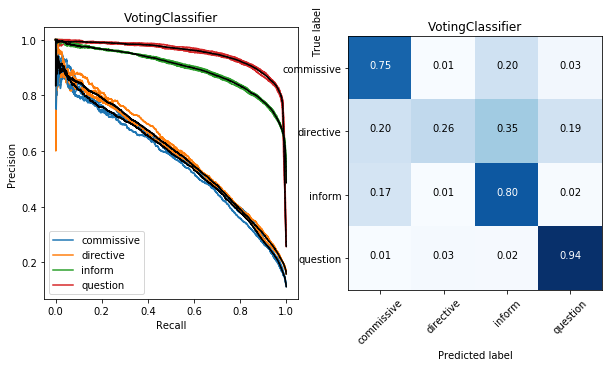

In [61]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

# Pickle Model for deploy

In [6]:
from chatty.model import save_model

In [7]:
clf.fit(X, y)

-- Epoch 1
-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 27.48, NNZs: 83523, Bias: -0.865527, T: 75707, Avg. loss: 0.409944
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 27.88, NNZs: 83523, Bias: 0.195667, T: 75707, Avg. loss: 0.427727
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 20.37, NNZs: 83523, Bias: -0.556835, T: 75707, Avg. loss: 0.288645
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 27.62, NNZs: 83523, Bias: 0.206384, T: 151414, Avg. loss: 0.385732
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 27.14, NNZs: 83523, Bias: -0.948398, T: 151414, Avg. loss: 0.369428
Total training time: 0.29 seconds.
-- Epoch 3
Norm: 21.58, NNZs: 83523, Bias: -0.617454, T: 75707, Avg. loss: 0.149030
Total training time: 0.16 seconds.
Norm: 20.26, NNZs: 83523, Bias: -0.630480, T: 151414, Avg. loss: 0.265120
Total training time: 0.09 seconds.
-- Epoch 2
-- Epoch 3
Norm: 27.55, NNZs: 83523, Bias: 0.216991, T: 227121, Avg. loss: 0.383231
Total training time: 0.26 seconds.
-- Epoch 4
Nor

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1

Norm: 20.08, NNZs: 81928, Bias: -0.483787, T: 75708, Avg. loss: 0.292783
Total training time: 0.09 seconds.
-- Epoch 2
Norm: 26.20, NNZs: 81928, Bias: -0.746376, T: 75708, Avg. loss: 0.427823
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 21.83, NNZs: 81928, Bias: -0.565775, T: 75708, Avg. loss: 0.141606
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 26.18, NNZs: 81928, Bias: -0.022468, T: 75708, Avg. loss: 0.444279
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 19.81, NNZs: 81928, Bias: -0.536688, T: 151416, Avg. loss: 0.268077
Total training time: 0.17 seconds.
-- Epoch 3
Norm: 25.98, NNZs: 81928, Bias: -0.828186, T: 151416, Avg. loss: 0.385553
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 21.80, NNZs: 81928, Bias: -0.631571, T: 151416, Avg. loss: 0.131558
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 19.76, NNZs: 81928, Bias: -0.573891, T: 227124, Avg. loss: 0.266579
Total training time: 0.21 seconds.
-- Epoch 4


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


Norm: 25.85, NNZs: 81928, Bias: -0.925640, T: 378540, Avg. loss: 0.381198
Total training time: 0.45 seconds.
Convergence after 5 epochs took 0.45 seconds
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 27.08, NNZs: 79543, Bias: -0.920129, T: 75711, Avg. loss: 0.416906
Total training time: 0.07 seconds.
-- Epoch 2
-- Epoch 1
Norm: 27.69, NNZs: 79543, Bias: -0.037875, T: 75711, Avg. loss: 0.425462Norm: 22.18, NNZs: 79543, Bias: -0.625543, T: 75711, Avg. loss: 0.147230
Total training time: 0.17 seconds.
-- Epoch 2

Total training time: 0.12 seconds.
-- Epoch 2
Norm: 26.70, NNZs: 79543, Bias: -1.010636, T: 151422, Avg. loss: 0.374938
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 20.69, NNZs: 79543, Bias: -0.472494, T: 75711, Avg. loss: 0.281390
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 22.07, NNZs: 79543, Bias: -0.692365, T: 151422, Avg. loss: 0.136562
Total training time: 0.22 seconds.
-- Epoch 3
Norm: 27.41, NNZs: 79543, Bias: -0.023236, T: 151422, Avg. loss: 0.383728
Total traini

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1Norm: 31.63, NNZs: 45392, Bias: -0.816457, T: 75707, Avg. loss: 0.474715
Total training time: 0.13 seconds.
-- Epoch 2


Norm: 31.05, NNZs: 51720, Bias: -0.899193, T: 151414, Avg. loss: 0.368927
Total training time: 0.18 seconds.
-- Epoch 3
Norm: 32.30, NNZs: 53255, Bias: 0.228886, T: 75707, Avg. loss: 0.502704Norm: 17.25, NNZs: 38838, Bias: -0.651001, T: 75707, Avg. loss: 0.295591
Total training time: 0.18 seconds.
-- Epoch 2

Total training time: 0.07 seconds.
-- Epoch 2
Norm: 18.54, NNZs: 27695, Bias: -0.574354, T: 75707, Avg. loss: 0.153052
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 31.03, NNZs: 53453, Bias: -0.948944, T: 227121, Avg. loss: 0.358444
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 31.33, NNZs: 59302, Bias: 0.278531, T: 151414, Avg. loss: 0.394218
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 17.46, NNZs: 32042, Bias: -0.609763, T: 151414, Avg. loss: 0.121303
Total training time: 0.15 seconds.
-- Epoch 3
No

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 15.91, NNZs: 38440, Bias: -0.630398, T: 75708, Avg. loss: 0.300591
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 18.66, NNZs: 26038, Bias: -0.508217, T: 75708, Avg. loss: 0.142338
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 13.84, NNZs: 44384, Bias: -0.682115, T: 151416, Avg. loss: 0.234491
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 30.61, NNZs: 46343, Bias: -0.814413, T: 75708, Avg. loss: 0.507482
Total training time: 0.14 seconds.
Norm: 30.16, NNZs: 53187, Bias: 0.111739, T: 75708, Avg. loss: 0.535080-- Epoch 2

Total training time: 0.13 seconds.
-- Epoch 2
Norm: 17.83, NNZs: 30095, Bias: -0.552869, T: 151416, Avg. loss: 0.113509
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 12.87, NNZs: 47176, Bias: -0.714423, T: 227124, Avg. loss: 0.228849
Total training time: 0.21 seconds.
-- Epoch 4
Norm: 17.48, NNZs: 31597, Bias: -0.572678, T: 227124, Avg. loss: 0.110682
Total training time: 0.21 seconds.
-- Epoch 4
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 19.63, NNZs: 26476, Bias: -0.484658, T: 75711, Avg. loss: 0.150872
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 17.40, NNZs: 35582, Bias: -0.600759, T: 75711, Avg. loss: 0.290327
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 15.35, NNZs: 40752, Bias: -0.659861, T: 151422, Avg. loss: 0.228641
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 31.83, NNZs: 50755, Bias: 0.077816, T: 75711, Avg. loss: 0.504096
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 18.67, NNZs: 30485, Bias: -0.525687, T: 151422, Avg. loss: 0.118471
Norm: 14.59, NNZs: 43093, Bias: -0.681847, T: 227133, Avg. loss: 0.223066Total training time: 0.10 seconds.
-- Epoch 3
Norm: 31.09, NNZs: 44454, Bias: -0.984675, T: 75711, Avg. loss: 0.484967
Total training time: 0.10 seconds.
-- Epoch 2

Total training time: 0.12 seconds.
-- Epoch 4
Norm: 30.60, NNZs: 50421, Bias: -1.057523, T: 151422, Avg. loss: 0.378021
Total training time: 0.16 seconds.
-- Epoch 3
N

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


Pipeline(memory=None,
     steps=[('feature_union_countvecs', FeatureUnion(n_jobs=1,
       transformer_list=[('vocab', <chatty.utils.vectorize.CountVectorizerColumnN object at 0x7f73376475f8>), ('vocab_t-1', <chatty.utils.vectorize.CountVectorizerColumnN object at 0x7f7337647710>)],
       transformer_weights=None)), ('rando...cv=3, method='sigmoid'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None))])

In [8]:
save_model(clf, 'speech_act')

saving: /home/ubuntu/chatty/research/daily_dialogue/speech_act.pkl


##### XGB maxdepth=3, SGDclassifier (hinge loss, calibrated), RandomForest(calibrated), LogisticREgression(calibrated)
##### with added trigrams on pos and lemma PLUS COSINE of VECTORS and VECTORS!
##### Bigrammifying the chunk _ POS stuff

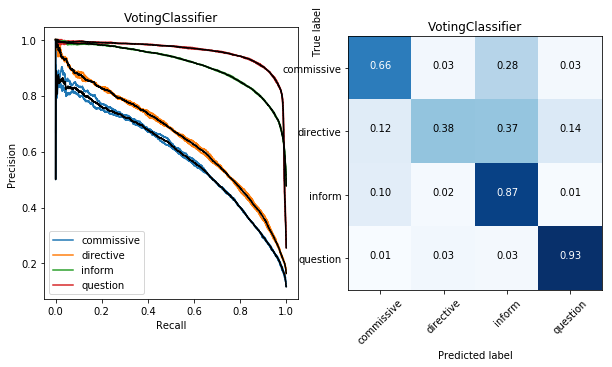

In [56]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

In [ ]:
clf.fit(X, y)

### Look at FEature Importance for Seventh Shot

In [27]:
features = list(enumerate(sorted(zip(clf.steps[0][1].get_feature_names(), clf.steps[2][1].feature_importances_),
       key=lambda x: x[1], reverse=True)))

In [29]:
list(filter(lambda x: 'vecs' in x[1][0], features))

[(345, ('vecs_t0_diff_t1__cosine_similarity2_302_302_602', 0.0007178751)),
 (310663, ('vecs_t0_diff_t2__cosine_similarity2_302_602_902', 0.0))]

In [30]:
list(filter(lambda x: 'LEMMA' in x[1][0], features))

[(0, ('vocab__LEMMA_?', 0.06532663)),
 (1, ('vocab_t-1__LEMMA_?', 0.028715003)),
 (2, ('vocab__LEMMA_do_LEMMA_-PRON-', 0.023689877)),
 (4, ('vocab__LEMMA_?_LEMMA_-PRON-', 0.013280689)),
 (5, ('vocab__LEMMA_how_LEMMA_about', 0.010409188)),
 (6, ('vocab_t-1__LEMMA_do_LEMMA_-PRON-', 0.010050251)),
 (8, ('vocab_t-1__LEMMA_how_LEMMA_about', 0.0093323765)),
 (10, ('vocab__LEMMA_what', 0.008973438)),
 (12, ('vocab_t-1__LEMMA_be', 0.008973438)),
 (13, ('vocab_t-1__LEMMA_please', 0.008973438)),
 (14, ('vocab__LEMMA_.', 0.008255564)),
 (15, ('vocab__LEMMA_please', 0.008255564)),
 (17, ('vocab__LEMMA_can_LEMMA_-PRON-', 0.007896626)),
 (18, ('vocab__LEMMA_wonder', 0.007896626)),
 (20, ('vocab_t-1__LEMMA_can', 0.0075376886)),
 (21, ('vocab_t-1__LEMMA_ ', 0.007178751)),
 (25, ('vocab__LEMMA_how', 0.0064608757)),
 (26, ('vocab__LEMMA_will', 0.0064608757)),
 (28, ('vocab__LEMMA_ ', 0.0061019384)),
 (29, ('vocab__LEMMA_really_LEMMA_?', 0.0057430007)),
 (30, ('vocab__LEMMA_thank', 0.0057430007)),
 (31, 

In [31]:
features

[(0, ('vocab__LEMMA_?', 0.06532663)),
 (1, ('vocab_t-1__LEMMA_?', 0.028715003)),
 (2, ('vocab__LEMMA_do_LEMMA_-PRON-', 0.023689877)),
 (3, ('vocab__POS_VERB_POS_PRON_POS_VERB', 0.014716439)),
 (4, ('vocab__LEMMA_?_LEMMA_-PRON-', 0.013280689)),
 (5, ('vocab__LEMMA_how_LEMMA_about', 0.010409188)),
 (6, ('vocab_t-1__LEMMA_do_LEMMA_-PRON-', 0.010050251)),
 (7, ('vocab__POS_PUNCT_POS_VERB_POS_PRON', 0.009691314)),
 (8, ('vocab_t-1__LEMMA_how_LEMMA_about', 0.0093323765)),
 (9, ('vectors__vectors_t0160', 0.0093323765)),
 (10, ('vocab__LEMMA_what', 0.008973438)),
 (11, ('vocab__POS_ADV_POS_VERB_POS_PRON', 0.008973438)),
 (12, ('vocab_t-1__LEMMA_be', 0.008973438)),
 (13, ('vocab_t-1__LEMMA_please', 0.008973438)),
 (14, ('vocab__LEMMA_.', 0.008255564)),
 (15, ('vocab__LEMMA_please', 0.008255564)),
 (16, ('vocab__POS_PUNCT_POS_PRON', 0.008255564)),
 (17, ('vocab__LEMMA_can_LEMMA_-PRON-', 0.007896626)),
 (18, ('vocab__LEMMA_wonder', 0.007896626)),
 (19, ('vocab__POS_NOUN_POS_VERB', 0.007896626)),


In [20]:
ignore_features = sorted(zip(clf.steps[0][1].get_feature_names(), clf.steps[2][1].feature_importances_),
       key=lambda x: x[1], reverse=True)[1000:]
ignore_features = [i for i, j in ignore_features]

(0, 400)

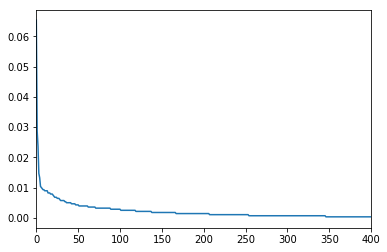

In [16]:
plt.plot(sorted(clf.steps[2][1].feature_importances_, reverse=True))
plt.xlim(0, 400)

---------------------

##### XGB maxdepth=3, SGDclassifier (hinge loss, calibrated), RandomForest
##### with added trigrams on pos and lemma PLUS COSINE of VECTORS and VECTORS!
##### Bigrammifying the chunk _ POS stuff

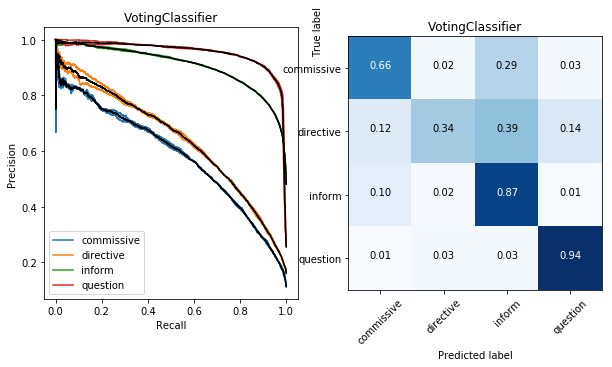

In [49]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### XGB maxdepth=3, SGDclassifier penalty l1 
##### with added trigrams on pos and lemma PLUS COSINE of VECTORS and VECTORS!
##### Bigrammifying the chunk _ POS stuff

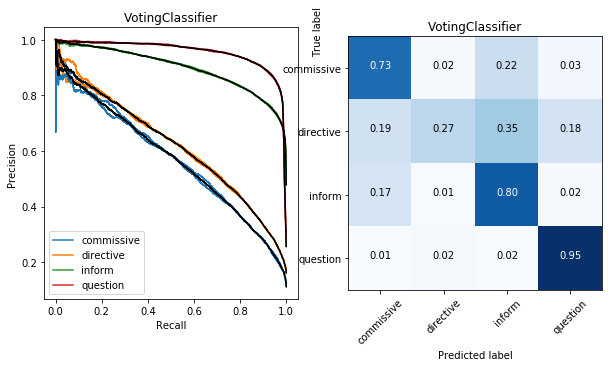

In [12]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### XGB maxdepth=3, SGDclassifier penalty l1 with added trigrams on pos and lemma PLUS COSINE of VECTORS and VECTORS!

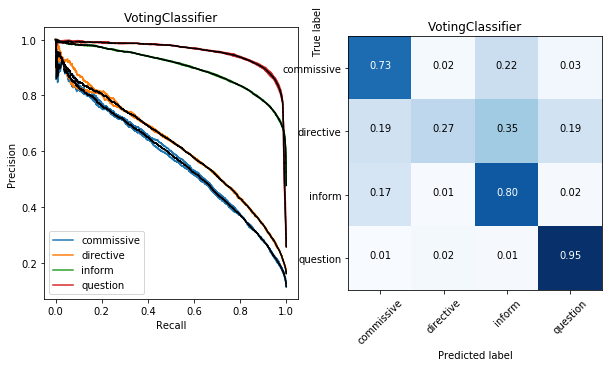

In [40]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### XGB, maxdepth=5, SGDclassifier with added trigrams on pos and lemma PLUS COSINE of VECTORS and VECTORS!

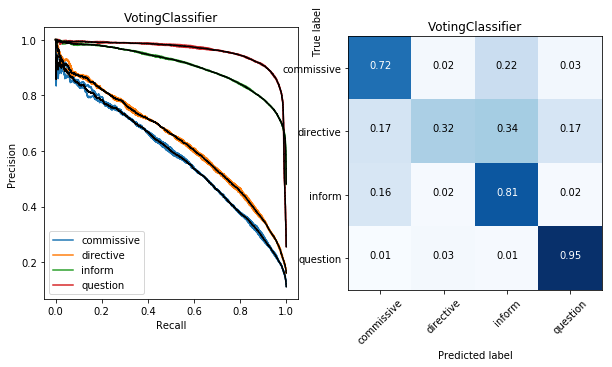

In [36]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### XGB maxdepth=5 with added trigrams on pos and lemma PLUS COSINE of VECTORS and VECTORS!

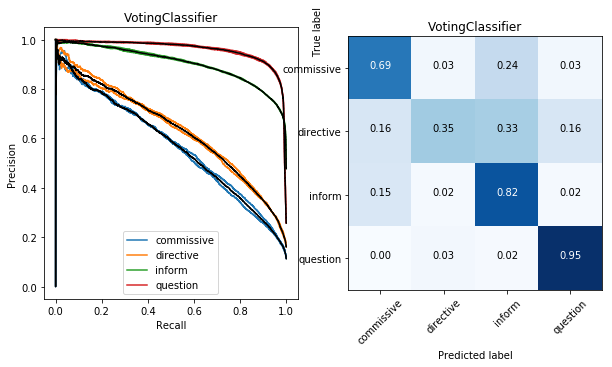

In [33]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### Logreg(RFE), SVC, Adaboost with added trigrams on pos and lemma PLUS COSINE of VECTORS include T-2!

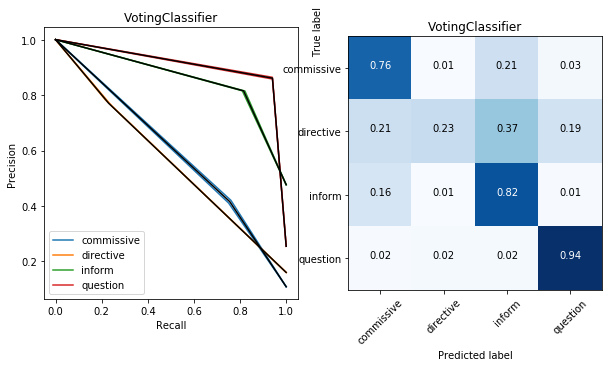

In [571]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=False)

##### Logreg, Adaboost with added trigrams on pos and lemma PLUS COSINE of VECTORS include T-2!

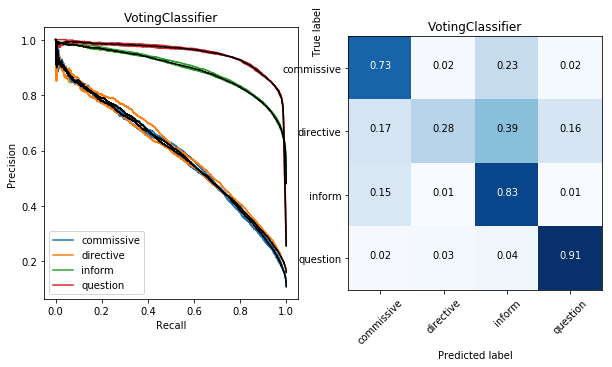

In [561]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### Logreg, AdaBoost with added trigrams on pos and lemma PLUS COSINE of VECTORS!

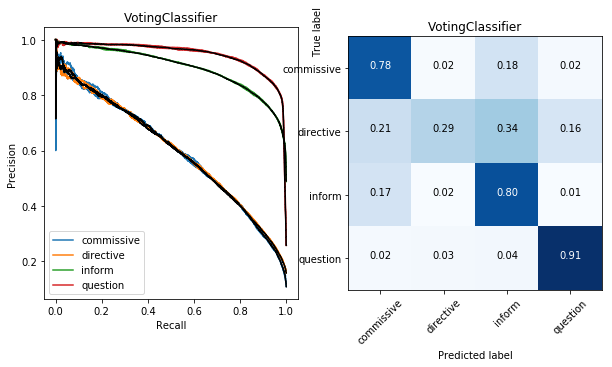

In [537]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### Logreg, ADABoost with added trigrams on pos and lemma PLUS COSINE of VECTORS!

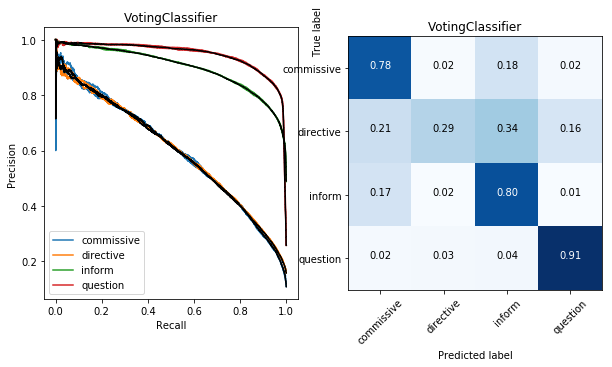

In [537]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### Logreg, ADABoost with added trigrams on pos and lemma PLUS VECTORS!

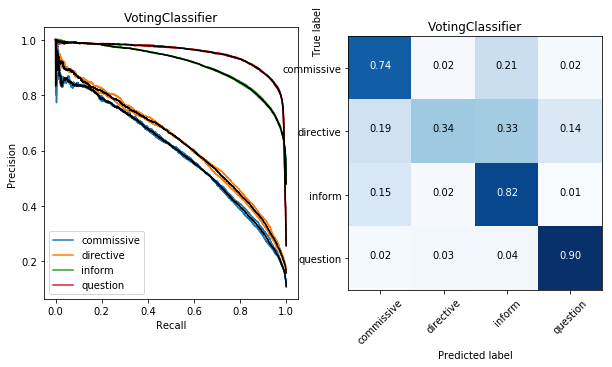

In [320]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### Logreg, BNB, DT with added trigrams on pos and lemma

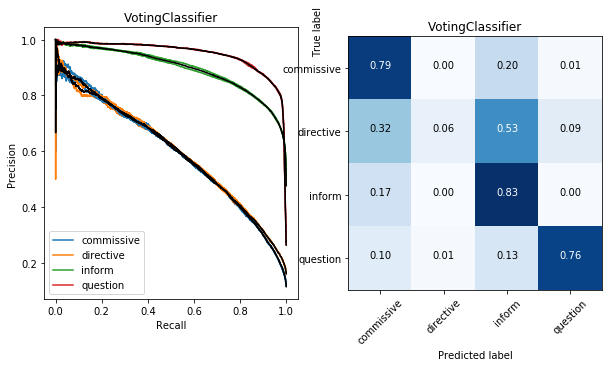

In [9]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=True)

##### Logreg, SVC, AdaBoost with added trigrams on pos and lemma

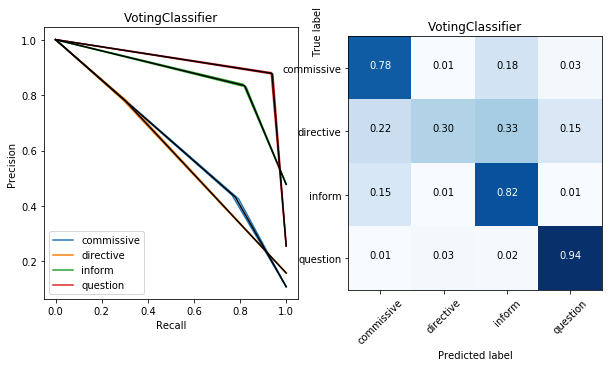

In [8]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True, probabilities=False)

What is being missed in directive?

##### Logreg(calibrated), SVC(calibrated), BernoulliNB with added trigrams on pos and lemma (with RFE on linears)

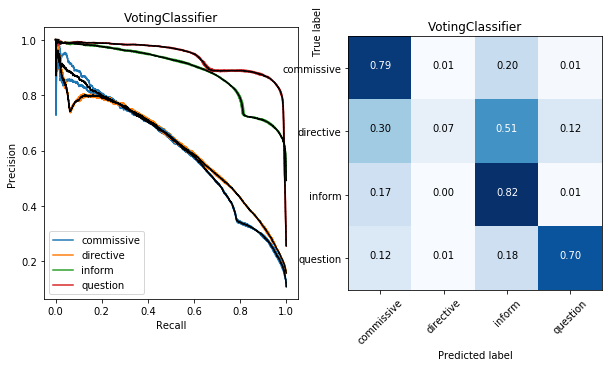

In [96]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

##### Try with calibrated SVM BernoulliNB and DecisionTree and no adaboost and with \*\*\*Recursive Feature Elimination\*\*\*

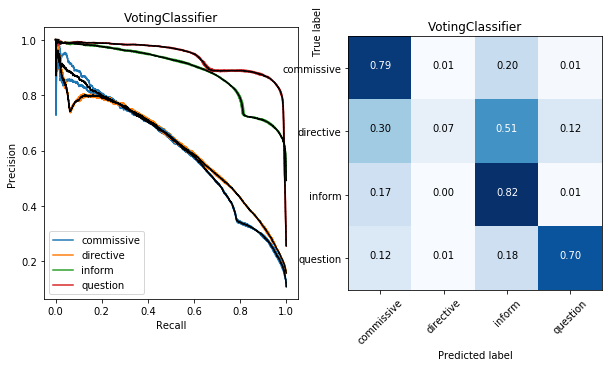

In [95]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

##### Try with calibrated SVM and BernoulliNB(calibrated) and Logistic Regression(calibrated) and DecisionTree (calibrated)

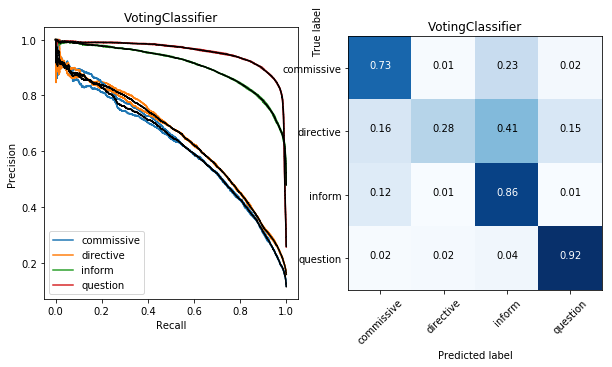

In [28]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

##### Try with calibrated SVM and BernoulliNB(calibrated) and Adaboost and Logistic REgression(calibrated)

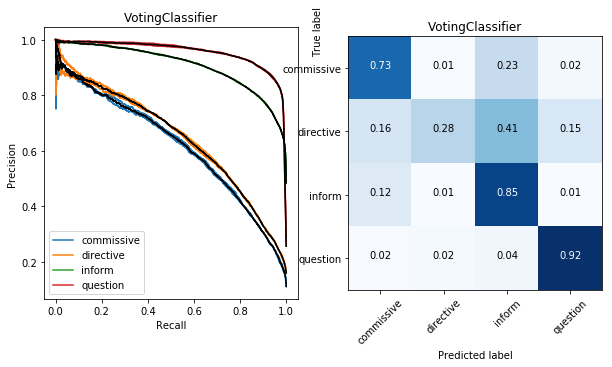

In [25]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

##### Try with SVM(calibrated) and Adaboost and Logistic REgression(calibrated)

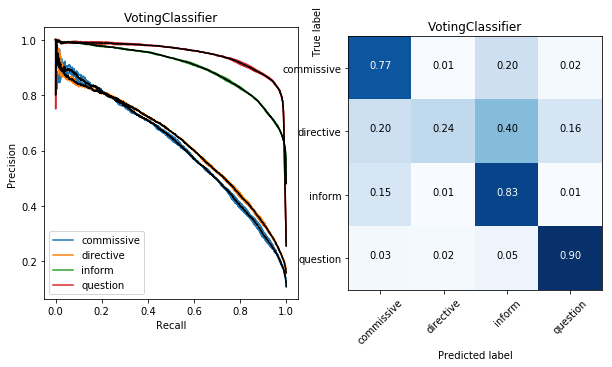

In [22]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)

In [24]:
results = data.cv_stratified_shuffle(X, y, clf, splits=2)

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


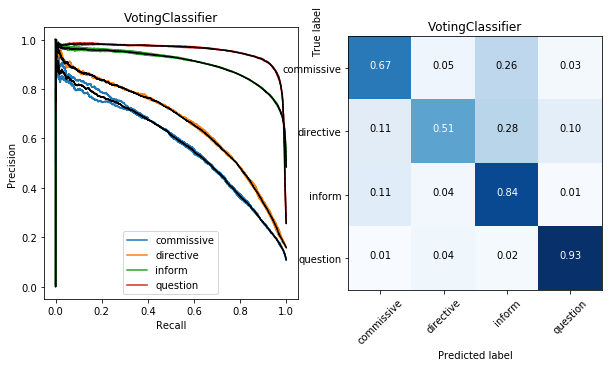

In [25]:
plot.plot_prec_rec(results, 'VotingClassifier', normalize_confusion_matrix=True)